[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Abade_and_Albuquerque_2024/fig_2.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Abade_and_Albuquerque_2024/fig_2.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Abade_and_Albuquerque_2024/fig_2.ipynb)

#### based on Fig. 2 from Abade & Albuquerque 2024 (QJRMS)  "_Persistent mixed‐phase states in adiabatic cloud parcels under idealised conditions_"

(work in progress!) # TODO #1656

https://doi.org/10.1002/qj.4775

In [3]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [8]:
import numpy as np
from matplotlib import pyplot
from open_atmos_jupyter_utils import show_plot
from PySDM.physics import si, in_unit
from PySDM_examples.utils.widgets import display, FloatProgress
from PySDM_examples.Abade_and_Albuquerque_2024 import Simulation, Settings

In [30]:
t_max = 6000 * si.s
t_out = 100 * si.s
n_realisations = 3
seeds = range(n_realisations)
n_sds = (64, 256) # PAPER: "on the order of 1e6"

display(progbar := FloatProgress(value=1, description='sampling', max=1 + 2 * len(seeds) * len(n_sds)))

simulations = {
    'Bulk': [Simulation(Settings(
        timestep=1 * si.s,
        n_sd=1,
        enable_immersion_freezing=False,
        enable_vapour_deposition_on_ice=False,
    ))]
}

homogenous_commons = {
    'timestep': .5 * si.s,
    'inp_frac': .5, # PAPER: .1
    'enable_immersion_freezing': True,
    'enable_vapour_deposition_on_ice': True,
}

for n_sd in n_sds:
    for singular, label in {True: 'INAS', False: 'ABIFM'}.items():
        simulations[f'Homogeneous-{label}-{n_sd}'] = []
        for seed in seeds:
            progbar.description = '...' + key[-7:] + f'-{seed}'
            simulations[f'Homogeneous-{label}-{n_sd}'].append(
                Simulation(Settings(**homogenous_commons, n_sd=n_sd, singular=singular, seed=seed))
            )
            progbar.value += 1

FloatProgress(value=1.0, description='sampling', max=13.0)

In [31]:
display(progbar := FloatProgress(value=0, description='simulating', max=1 + 2 * len(seeds) * len(n_sds)))

datasets = {}
for key, val in simulations.items():
    datasets[key] = {'realisations': []}
    for val_i in val:
        progbar.description = '...' + key[-7:] + f'-{seed}'
        val_i.run(
            nt=int(t_max / val_i.particulator.dt),
            steps_per_output_interval=int(t_out / val_i.particulator.dt)
        )
        progbar.value +=1

FloatProgress(value=0.0, description='simulating', max=13.0)

AssertionError: 

In [23]:
def plot(dataset, n_sd):
    ax = None
    for label, ax in reversed(axs.items()):
        ax.set_xlabel(r"r (g$\cdot$kg$^{-1}$)")
        ax.set_title(label)
        ax.set_ylim(0, 3)
        ax.grid()
    ax.set_ylabel('Height (km)')
    
    values = {key:{} for key in (f'Homogeneous-INAS-{n_sd}', f'Homogeneous-ABIFM-{n_sd}', f'Bulk-{n_sd}')}
    
    colors = {
        'total': 'black',
        'ice': 'gray',
        'water': 'blue',
    }
    
    for key in (f'Homogeneous-INAS-{n_sd}', f'Homogeneous-ABIFM-{n_sd}'):
        # compute the total water
        for realisation in dataset[key]['realisations']:
            realisation['total'] = np.asarray(realisation['water']) + np.asarray(realisation['ice'])
    
        # compute the means
        dataset[key]['mean'] = {}
        for name in ('ice', 'water', 'total', 'height'):
            dataset[key]['mean'][name] = [
                np.mean([realisation[name][level] for realisation in dataset[key]['realisations']]) 
                for level in range(len(dataset[key]['realisations'][0][name]))
            ]
    
    # Homogeneous
    for key in (f'Homogeneous-INAS-{n_sd}', f'Homogeneous-ABIFM-{n_sd}'):
        for name in ('ice', 'water', 'total'):
            for realisation in dataset[key]['realisations']:
                axs[key].plot(
                    in_unit(np.asarray(realisation[name]), si.g / si.kg),
                    in_unit(np.asarray(realisation['height']), si.km),
                    linestyle='--' if name == 'total' else '-',
                    color=colors[name],
                    linewidth=.75,
                )
            mean = dataset[key]['mean']
            axs[key].plot(
                in_unit(np.asarray(mean[name]), si.g / si.kg),
                in_unit(np.asarray(mean['height']), si.km),
                label=name,
                marker='.',
                color=colors[name],
            )
    
    # Bulk
    bulk_key = f'Bulk-{n_sd}'
    assert len(simulations[n_sd][bulk_key]) == 1
    simulation = simulations[n_sd][bulk_key][0]
    bulk_output = dataset[bulk_key]['realisations'][0]
    liquid_fraction = simulation.particulator.formulae.bulk_phase_partitioning.liquid_fraction(np.asarray(bulk_output['T']))
    total_water_mixing_ratio = np.asarray(bulk_output['water'])
    for name in ('ice', 'water', 'total'):
        values[bulk_key][name] = {
            'total': total_water_mixing_ratio,
            'ice': (1 - liquid_fraction) * total_water_mixing_ratio,
            'water': liquid_fraction * total_water_mixing_ratio
        }[name]
        
        axs[bulk_key].plot(
            in_unit(values[bulk_key][name], si.g / si.kg),
            in_unit(np.asarray(bulk_output['height']), si.km),
            label=name,
            marker='.',
            color=colors[name],
            linestyle='--' if name == 'total' else '-'
        )
    axs[bulk_key].legend()

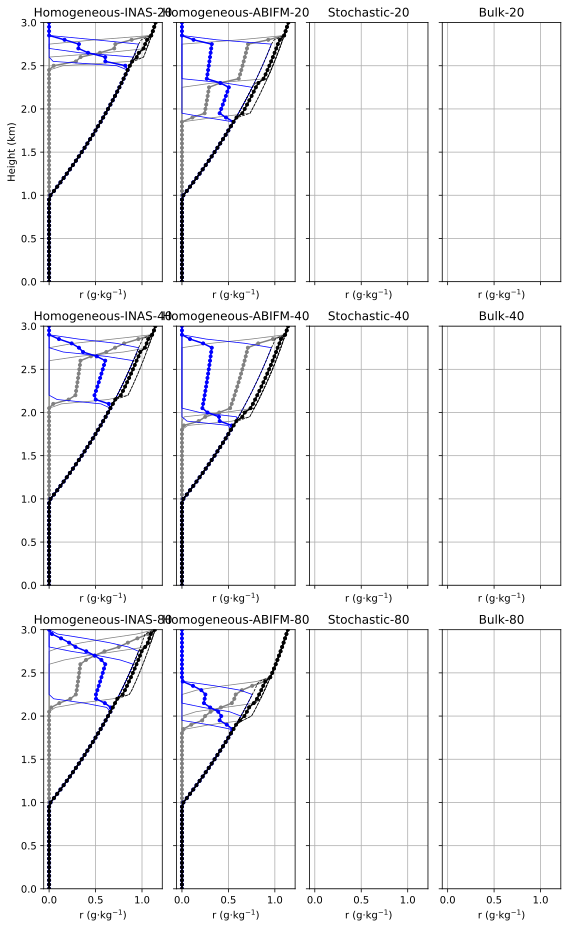

In [25]:
fig, axs = pyplot.subplot_mosaic(
    [
        [
            f'Homogeneous-INAS-{n_sd}',
            f'Homogeneous-ABIFM-{n_sd}',
            f'Stochastic-{n_sd}',
            f'Bulk-{n_sd}'
        ]
        for n_sd in datasets.keys()
    ],
    figsize=(8, 13),
    sharex=True,
    sharey=True,
    tight_layout=True,
)
for n_sd, dataset in datasets.items():
    plot(dataset, n_sd)
show_plot('fig_2.pdf')